In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:2]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
selected

['009265_hippoSIT_2023-02-24_09-53-26', '009265_hippoSIT_2023-02-24_17-22-46']

(2483,) (2919,)
(2466,) (2898,)


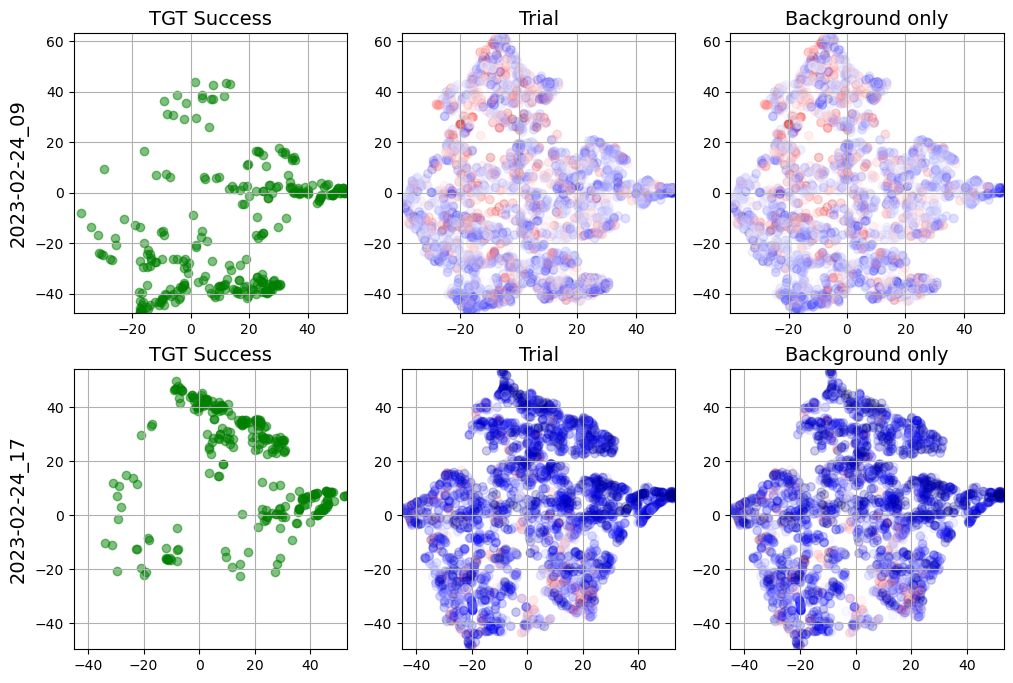

In [10]:
fit_type = 'tSNE'
fit_parm = 70
#fit_type = 'UMAP'
#fit_parm = 0.5

rows = len(selected)
cols = 3
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
        
    w_pca = activity_at_phase(s_path, 4, do_pca=True)
    w_int = np.interp(tl[idxs_srm_tl][:, 0], events[:, 0], w_pca)
    #w_int = stats.zscore(w_int)

    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_tgt = np.where(tl[idxs_srm_tl][:, 6] == 2)[0]
    idxs_srm_trial = np.union1d(idxs_srm_bgr, idxs_srm_tgt)

    x_min, x_max = fit[:, 0].min(), fit[:, 0].max()
    y_min, y_max = fit[:, 1].min(), fit[:, 1].max()

    ax = axes[i][0]
    ax.scatter(fit[idxs_srm_succ][:, 0], fit[idxs_srm_succ][:, 1], alpha=0.5, color='green')
    ax.set_title('TGT Success', fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(session[-19:-6], fontsize=14)
    ax.grid()

    ax = axes[i][1]
    ax.scatter(fit[idxs_srm_trial][:, 0], fit[idxs_srm_trial][:, 1], alpha=0.2, cmap='seismic', c=w_int[idxs_srm_trial])
    ax.set_title('Trial', fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid()

    ax = axes[i][2]
    ax.scatter(fit[idxs_srm_bgr][:, 0], fit[idxs_srm_bgr][:, 1], alpha=0.2, cmap='seismic', c=w_int[idxs_srm_bgr])
    ax.set_title('Background only', fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid()

    print(idxs_srm_bgr.shape, idxs_srm_trial.shape)
    #idxs_high    = np.where(w_int > w_int[idxs_srm_bgr].mean())[0]
    #idxs_low     = np.where(w_int < w_int[idxs_srm_bgr].mean())[0]
    #idxs_high    = np.intersect1d(idxs_srm_bgr, idxs_high)
    #idxs_low     = np.intersect1d(idxs_srm_bgr, idxs_low)

    # x_min, x_max = fit[:, 0].min(), fit[:, 0].max()
    # y_min, y_max = fit[:, 1].min(), fit[:, 1].max()
    # idxs_list = [idxs_high, idxs_high, idxs_low]
    # colors    = ['red', 'red', 'blue', 'green']
    # titles    = ['Background', 'W4 High', 'W4 Low', 'Success in target']
    # for j, idxs in enumerate(idxs_list):
    #     ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=w_int)

    #     ax = axes[i][j]
    #     #ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, color='black')
    #     ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=0.05, color=colors[j])
    #     if j == 0:
    #         ax.scatter(fit[idxs_low][:, 0], fit[idxs_low][:, 1], alpha=0.05, color='blue')
    #     ax.set_title(titles[j], fontsize=14)
    #     ax.set_xlim(x_min, x_max)
    #     ax.set_ylim(y_min, y_max)
    #     if j == 0:
    #         ax.set_ylabel(session[-19:-6], fontsize=14)
    #     ax.grid()

In [11]:
idxs_srm_bgr

array([   0,    1,    2, ..., 4764, 4765, 4766])